# LSTM - vanilla

In [12]:
best_model = "best_model0.pt"

## Load and prepare data

In [13]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [14]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


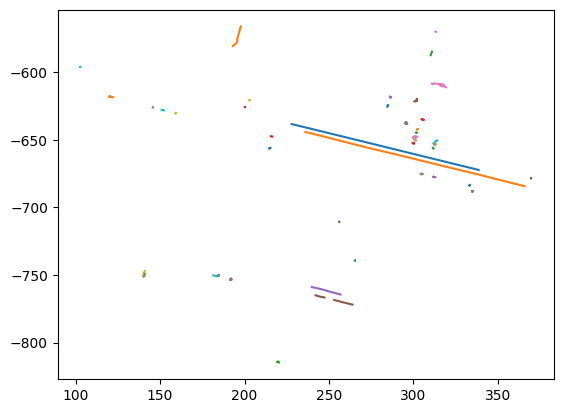

In [15]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [16]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, 2:4].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )
        
        # print(f'x: {data_item.x.shape}')
        # print(f'y: {data_item.y.shape}')

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [17]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [23]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    # 2 layers 9.77 val
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.ego_encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.neighbor_encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim*2, output_dim)
        
        # Initialize weights properly
        # for name, param in self.named_parameters():
        #     if 'weight' in name:
        #         nn.init.xavier_normal_(param)
        #     elif 'bias' in name:
        #         nn.init.constant_(param, 0.0)
        
    def forward(self, data):
        x = data.x[..., :5]
        x = x.reshape(-1, 50, 50, 5)  # (batch_size, num_agents, seq_len, input_dim)
        batch_size = x.size(0)
        # x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
        # EGO AGENT
        ego_traj = x[:, 0, :, :]  # (batch, 50, 5)
        # Process through LSTM
        ego_lstm_out, _ = self.ego_encoder(ego_traj)
        # Extract final hidden state
        ego_features = ego_lstm_out[:, -1, :]
        
        # CLOSEST NEIGHBOR
        # ---- DISTANCES TO OTHER AGENTS ----
        ego_pos = x[:, 0, 49, :2].unsqueeze(1)  # (batch, 1, 2)
        agent_pos = x[:, :, 49, :2]  # (batch, 50, 2)
        dists = torch.norm(agent_pos - ego_pos, dim=-1)  # (batch, 50)
        dists[:, 0] = float('inf')  # mask out ego
        
        _, neighbor_ids = torch.topk(dists, k=1, dim=1, largest=False)  # (batch, 3)
        
        # ---- ENCODE NEIGHBORS ----
        neighbor_out_list = []

        for i in range(1):
            idx = neighbor_ids[:, i]  # (batch,)
            neighbor_trajs = torch.stack([x[b, idx[b]] for b in range(batch_size)], dim=0)  # (batch, 50, 5)

            neighbor_lstm_out, _ = self.neighbor_encoder(neighbor_trajs)  # both: (num_layers, batch, hidden_dim)

            neighbor_out_list.append(neighbor_lstm_out[:, -1, :])

        # ---- CONCATENATE HIDDEN AND CELL STATES ----
        all_features = torch.cat([ego_features] + neighbor_out_list, dim=1)  # (num_layers, batch, hidden_dim * 4)
        
        # Process through prediction head
        features = self.relu(self.fc1(all_features))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

# Train

In [24]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1)
                y_unnorm = y * batch.scale.view(-1, 1, 1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [27]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM()
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.005,  # Lower learning rate
        patience=20,  # More patience
        epochs=150
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1)
            y = y * batch.scale.view(-1, 1, 1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [28]:
# bigger hidden size
train_and_evaluate_model()

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_2003/1407810273.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   1%|          | 1/150 [00:32<1:20:04, 32.24s/epoch]

Epoch 000 | LR 0.004750 | Train MSE 0.8328 | Val MSE 0.0841 | Val MAE 1.3813 | Val MSE 4.1215
Sample pred first 3 steps: [[-0.02735776 -0.09875301]
 [-0.02192179 -0.09730278]
 [-0.02735442 -0.10102975]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: inf -> 0.084112


Epoch:   1%|▏         | 2/150 [01:02<1:16:14, 30.91s/epoch]

Epoch 001 | LR 0.004513 | Train MSE 0.1061 | Val MSE 0.0876 | Val MAE 1.4865 | Val MSE 4.2943


Epoch:   2%|▏         | 3/150 [01:32<1:14:37, 30.46s/epoch]

Epoch 002 | LR 0.004287 | Train MSE 0.0940 | Val MSE 0.0726 | Val MAE 1.2855 | Val MSE 3.5570
Validation improved: 0.084112 -> 0.072591


Epoch:   3%|▎         | 4/150 [02:02<1:13:41, 30.29s/epoch]

Epoch 003 | LR 0.004073 | Train MSE 0.0856 | Val MSE 0.0546 | Val MAE 1.0437 | Val MSE 2.6746
Validation improved: 0.072591 -> 0.054584


Epoch:   3%|▎         | 5/150 [02:31<1:12:44, 30.10s/epoch]

Epoch 004 | LR 0.003869 | Train MSE 0.0809 | Val MSE 0.0527 | Val MAE 0.9939 | Val MSE 2.5807
Validation improved: 0.054584 -> 0.052667


Epoch:   4%|▍         | 6/150 [03:02<1:12:19, 30.13s/epoch]

Epoch 005 | LR 0.003675 | Train MSE 0.0829 | Val MSE 0.0563 | Val MAE 1.0697 | Val MSE 2.7580
Sample pred first 3 steps: [[0.0217641  0.07270833]
 [0.0226773  0.07311898]
 [0.0234639  0.07362744]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   5%|▍         | 7/150 [03:32<1:11:45, 30.11s/epoch]

Epoch 006 | LR 0.003492 | Train MSE 0.0815 | Val MSE 0.0502 | Val MAE 0.9534 | Val MSE 2.4619
Validation improved: 0.052667 -> 0.050243


Epoch:   5%|▌         | 8/150 [04:02<1:11:08, 30.06s/epoch]

Epoch 007 | LR 0.003317 | Train MSE 0.0760 | Val MSE 0.0560 | Val MAE 1.0920 | Val MSE 2.7450


Epoch:   6%|▌         | 9/150 [04:31<1:10:24, 29.96s/epoch]

Epoch 008 | LR 0.003151 | Train MSE 0.0861 | Val MSE 0.0560 | Val MAE 1.1831 | Val MSE 2.7460


Epoch:   7%|▋         | 10/150 [05:02<1:10:12, 30.09s/epoch]

Epoch 009 | LR 0.002994 | Train MSE 0.0764 | Val MSE 0.0470 | Val MAE 0.9041 | Val MSE 2.3022
Validation improved: 0.050243 -> 0.046984


Epoch:   7%|▋         | 11/150 [05:31<1:09:27, 29.98s/epoch]

Epoch 010 | LR 0.002844 | Train MSE 0.0729 | Val MSE 0.0508 | Val MAE 0.9815 | Val MSE 2.4889
Sample pred first 3 steps: [[0.05241035 0.02489687]
 [0.05238713 0.0248609 ]
 [0.0531923  0.02577305]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   8%|▊         | 12/150 [06:01<1:08:53, 29.95s/epoch]

Epoch 011 | LR 0.002702 | Train MSE 0.0706 | Val MSE 0.0473 | Val MAE 0.9143 | Val MSE 2.3158


Epoch:   9%|▊         | 13/150 [06:32<1:08:40, 30.08s/epoch]

Epoch 012 | LR 0.002567 | Train MSE 0.0685 | Val MSE 0.0454 | Val MAE 0.8696 | Val MSE 2.2255
Validation improved: 0.046984 -> 0.045418


Epoch:   9%|▉         | 14/150 [07:02<1:08:09, 30.07s/epoch]

Epoch 013 | LR 0.002438 | Train MSE 0.0699 | Val MSE 0.0494 | Val MAE 0.9759 | Val MSE 2.4217


Epoch:  10%|█         | 15/150 [07:32<1:07:58, 30.21s/epoch]

Epoch 014 | LR 0.002316 | Train MSE 0.0662 | Val MSE 0.0500 | Val MAE 1.0561 | Val MSE 2.4480


Epoch:  11%|█         | 16/150 [08:03<1:07:39, 30.30s/epoch]

Epoch 015 | LR 0.002201 | Train MSE 0.0634 | Val MSE 0.0416 | Val MAE 0.8467 | Val MSE 2.0373
Sample pred first 3 steps: [[0.02535004 0.04988671]
 [0.02554228 0.04942827]
 [0.02527672 0.04895309]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.045418 -> 0.041578


Epoch:  11%|█▏        | 17/150 [08:34<1:07:31, 30.46s/epoch]

Epoch 016 | LR 0.002091 | Train MSE 0.0616 | Val MSE 0.0434 | Val MAE 0.8717 | Val MSE 2.1250


Epoch:  12%|█▏        | 18/150 [09:06<1:08:18, 31.05s/epoch]

Epoch 017 | LR 0.001986 | Train MSE 0.0655 | Val MSE 0.0424 | Val MAE 0.9012 | Val MSE 2.0754


Epoch:  13%|█▎        | 19/150 [09:37<1:07:29, 30.91s/epoch]

Epoch 018 | LR 0.001887 | Train MSE 0.0598 | Val MSE 0.0412 | Val MAE 0.8649 | Val MSE 2.0185
Validation improved: 0.041578 -> 0.041195


Epoch:  13%|█▎        | 20/150 [10:07<1:06:52, 30.86s/epoch]

Epoch 019 | LR 0.001792 | Train MSE 0.0643 | Val MSE 0.0414 | Val MAE 0.8696 | Val MSE 2.0282


Epoch:  14%|█▍        | 21/150 [10:37<1:05:30, 30.47s/epoch]

Epoch 020 | LR 0.001703 | Train MSE 0.0569 | Val MSE 0.0404 | Val MAE 0.8384 | Val MSE 1.9785
Sample pred first 3 steps: [[-0.02787732 -0.00766414]
 [-0.02802666 -0.00698289]
 [-0.02823436 -0.00593945]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.041195 -> 0.040378


Epoch:  15%|█▍        | 22/150 [11:07<1:04:30, 30.24s/epoch]

Epoch 021 | LR 0.001618 | Train MSE 0.0553 | Val MSE 0.0428 | Val MAE 0.9336 | Val MSE 2.0967


Epoch:  15%|█▌        | 23/150 [11:38<1:04:23, 30.42s/epoch]

Epoch 022 | LR 0.001537 | Train MSE 0.0541 | Val MSE 0.0398 | Val MAE 0.8501 | Val MSE 1.9481
Validation improved: 0.040378 -> 0.039758


Epoch:  16%|█▌        | 24/150 [12:08<1:03:47, 30.37s/epoch]

Epoch 023 | LR 0.001460 | Train MSE 0.0538 | Val MSE 0.0399 | Val MAE 0.8470 | Val MSE 1.9549


Epoch:  17%|█▋        | 25/150 [12:37<1:02:19, 29.92s/epoch]

Epoch 024 | LR 0.001387 | Train MSE 0.0530 | Val MSE 0.0396 | Val MAE 0.8196 | Val MSE 1.9388
Validation improved: 0.039758 -> 0.039566


Epoch:  17%|█▋        | 26/150 [13:06<1:01:41, 29.85s/epoch]

Epoch 025 | LR 0.001318 | Train MSE 0.0523 | Val MSE 0.0376 | Val MAE 0.7687 | Val MSE 1.8421
Sample pred first 3 steps: [[ 0.00634578 -0.00158909]
 [ 0.00625383  0.00056327]
 [ 0.00638815  0.00270657]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.039566 -> 0.037593


Epoch:  18%|█▊        | 27/150 [13:37<1:01:37, 30.06s/epoch]

Epoch 026 | LR 0.001252 | Train MSE 0.0527 | Val MSE 0.0380 | Val MAE 0.7991 | Val MSE 1.8624


Epoch:  19%|█▊        | 28/150 [14:06<1:00:25, 29.72s/epoch]

Epoch 027 | LR 0.001189 | Train MSE 0.0520 | Val MSE 0.0375 | Val MAE 0.7640 | Val MSE 1.8387
Validation improved: 0.037593 -> 0.037524


Epoch:  19%|█▉        | 29/150 [14:37<1:00:58, 30.23s/epoch]

Epoch 028 | LR 0.001130 | Train MSE 0.0535 | Val MSE 0.0378 | Val MAE 0.7735 | Val MSE 1.8501


Epoch:  20%|██        | 30/150 [15:09<1:01:24, 30.71s/epoch]

Epoch 029 | LR 0.001073 | Train MSE 0.0498 | Val MSE 0.0372 | Val MAE 0.7675 | Val MSE 1.8215
Validation improved: 0.037524 -> 0.037174


Epoch:  21%|██        | 31/150 [15:41<1:01:19, 30.92s/epoch]

Epoch 030 | LR 0.001020 | Train MSE 0.0521 | Val MSE 0.0386 | Val MAE 0.7850 | Val MSE 1.8917
Sample pred first 3 steps: [[ 0.01080996 -0.01261113]
 [ 0.01024386 -0.01157063]
 [ 0.00979882 -0.01066115]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  21%|██▏       | 32/150 [16:13<1:01:39, 31.35s/epoch]

Epoch 031 | LR 0.000969 | Train MSE 0.0503 | Val MSE 0.0377 | Val MAE 0.7783 | Val MSE 1.8460


Epoch:  22%|██▏       | 33/150 [16:44<1:01:13, 31.40s/epoch]

Epoch 032 | LR 0.000920 | Train MSE 0.0498 | Val MSE 0.0379 | Val MAE 0.7984 | Val MSE 1.8574


Epoch:  23%|██▎       | 34/150 [17:15<1:00:12, 31.14s/epoch]

Epoch 033 | LR 0.000874 | Train MSE 0.0497 | Val MSE 0.0385 | Val MAE 0.7940 | Val MSE 1.8849


Epoch:  23%|██▎       | 35/150 [17:45<59:21, 30.97s/epoch]  

Epoch 034 | LR 0.000830 | Train MSE 0.0530 | Val MSE 0.0372 | Val MAE 0.7668 | Val MSE 1.8235


Epoch:  24%|██▍       | 36/150 [18:17<59:10, 31.14s/epoch]

Epoch 035 | LR 0.000789 | Train MSE 0.0487 | Val MSE 0.0377 | Val MAE 0.7985 | Val MSE 1.8480
Sample pred first 3 steps: [[ 0.025406   -0.00246074]
 [ 0.02706479 -0.00197148]
 [ 0.02849822 -0.00120786]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  25%|██▍       | 37/150 [18:49<58:53, 31.27s/epoch]

Epoch 036 | LR 0.000749 | Train MSE 0.0488 | Val MSE 0.0371 | Val MAE 0.7744 | Val MSE 1.8162
Validation improved: 0.037174 -> 0.037066


Epoch:  25%|██▌       | 38/150 [19:21<59:06, 31.67s/epoch]

Epoch 037 | LR 0.000712 | Train MSE 0.0482 | Val MSE 0.0380 | Val MAE 0.7886 | Val MSE 1.8616


Epoch:  26%|██▌       | 39/150 [19:52<57:52, 31.28s/epoch]

Epoch 038 | LR 0.000676 | Train MSE 0.0483 | Val MSE 0.0370 | Val MAE 0.7756 | Val MSE 1.8113
Validation improved: 0.037066 -> 0.036966


Epoch:  27%|██▋       | 40/150 [20:23<57:33, 31.39s/epoch]

Epoch 039 | LR 0.000643 | Train MSE 0.0479 | Val MSE 0.0373 | Val MAE 0.7725 | Val MSE 1.8282


Epoch:  27%|██▋       | 41/150 [20:55<57:12, 31.49s/epoch]

Epoch 040 | LR 0.000610 | Train MSE 0.0473 | Val MSE 0.0371 | Val MAE 0.7728 | Val MSE 1.8163
Sample pred first 3 steps: [[ 0.00065319  0.00607715]
 [-0.00043364  0.00716155]
 [-0.00142655  0.00803228]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  28%|██▊       | 42/150 [21:26<56:32, 31.41s/epoch]

Epoch 041 | LR 0.000580 | Train MSE 0.0479 | Val MSE 0.0361 | Val MAE 0.7511 | Val MSE 1.7706
Validation improved: 0.036966 -> 0.036136


Epoch:  29%|██▊       | 43/150 [21:57<55:57, 31.37s/epoch]

Epoch 042 | LR 0.000551 | Train MSE 0.0473 | Val MSE 0.0359 | Val MAE 0.7466 | Val MSE 1.7571
Validation improved: 0.036136 -> 0.035860


Epoch:  29%|██▉       | 44/150 [22:29<55:31, 31.43s/epoch]

Epoch 043 | LR 0.000523 | Train MSE 0.0477 | Val MSE 0.0393 | Val MAE 0.8239 | Val MSE 1.9277


Epoch:  30%|███       | 45/150 [23:01<55:28, 31.70s/epoch]

Epoch 044 | LR 0.000497 | Train MSE 0.0479 | Val MSE 0.0364 | Val MAE 0.7475 | Val MSE 1.7814


Epoch:  31%|███       | 46/150 [23:33<54:44, 31.58s/epoch]

Epoch 045 | LR 0.000472 | Train MSE 0.0470 | Val MSE 0.0364 | Val MAE 0.7781 | Val MSE 1.7838
Sample pred first 3 steps: [[ 0.03142744 -0.0031809 ]
 [ 0.03187694 -0.0031498 ]
 [ 0.03186364 -0.00282051]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  31%|███▏      | 47/150 [24:08<55:58, 32.61s/epoch]

Epoch 046 | LR 0.000449 | Train MSE 0.0471 | Val MSE 0.0364 | Val MAE 0.7496 | Val MSE 1.7825


Epoch:  32%|███▏      | 48/150 [24:43<56:36, 33.30s/epoch]

Epoch 047 | LR 0.000426 | Train MSE 0.0474 | Val MSE 0.0368 | Val MAE 0.7764 | Val MSE 1.8021


Epoch:  33%|███▎      | 49/150 [25:17<56:26, 33.53s/epoch]

Epoch 048 | LR 0.000405 | Train MSE 0.0465 | Val MSE 0.0384 | Val MAE 0.8176 | Val MSE 1.8803


Epoch:  33%|███▎      | 50/150 [25:53<57:08, 34.28s/epoch]

Epoch 049 | LR 0.000385 | Train MSE 0.0469 | Val MSE 0.0360 | Val MAE 0.7519 | Val MSE 1.7629


Epoch:  34%|███▍      | 51/150 [26:27<56:31, 34.26s/epoch]

Epoch 050 | LR 0.000365 | Train MSE 0.0461 | Val MSE 0.0354 | Val MAE 0.7344 | Val MSE 1.7337
Sample pred first 3 steps: [[-0.00023486 -0.00308024]
 [-0.0005455  -0.00175415]
 [-0.00087814 -0.00049892]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.035860 -> 0.035382


Epoch:  35%|███▍      | 52/150 [27:02<56:23, 34.53s/epoch]

Epoch 051 | LR 0.000347 | Train MSE 0.0462 | Val MSE 0.0360 | Val MAE 0.7535 | Val MSE 1.7644


Epoch:  35%|███▌      | 53/150 [27:36<55:44, 34.48s/epoch]

Epoch 052 | LR 0.000330 | Train MSE 0.0467 | Val MSE 0.0355 | Val MAE 0.7446 | Val MSE 1.7404


Epoch:  36%|███▌      | 54/150 [28:11<55:01, 34.39s/epoch]

Epoch 053 | LR 0.000313 | Train MSE 0.0462 | Val MSE 0.0363 | Val MAE 0.7617 | Val MSE 1.7792


Epoch:  37%|███▋      | 55/150 [28:45<54:18, 34.30s/epoch]

Epoch 054 | LR 0.000298 | Train MSE 0.0463 | Val MSE 0.0354 | Val MAE 0.7398 | Val MSE 1.7361


Epoch:  37%|███▋      | 56/150 [29:19<53:41, 34.27s/epoch]

Epoch 055 | LR 0.000283 | Train MSE 0.0468 | Val MSE 0.0363 | Val MAE 0.7645 | Val MSE 1.7765
Sample pred first 3 steps: [[ 0.01622508 -0.00640421]
 [ 0.01597784 -0.00542943]
 [ 0.015611   -0.00427708]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  38%|███▊      | 57/150 [29:54<53:22, 34.43s/epoch]

Epoch 056 | LR 0.000269 | Train MSE 0.0458 | Val MSE 0.0357 | Val MAE 0.7486 | Val MSE 1.7507


Epoch:  39%|███▊      | 58/150 [30:28<52:54, 34.51s/epoch]

Epoch 057 | LR 0.000255 | Train MSE 0.0457 | Val MSE 0.0359 | Val MAE 0.7396 | Val MSE 1.7587


Epoch:  39%|███▉      | 59/150 [31:02<51:52, 34.20s/epoch]

Epoch 058 | LR 0.000242 | Train MSE 0.0454 | Val MSE 0.0358 | Val MAE 0.7542 | Val MSE 1.7527


Epoch:  40%|████      | 60/150 [31:37<51:35, 34.40s/epoch]

Epoch 059 | LR 0.000230 | Train MSE 0.0453 | Val MSE 0.0363 | Val MAE 0.7507 | Val MSE 1.7797


Epoch:  41%|████      | 61/150 [32:10<50:40, 34.16s/epoch]

Epoch 060 | LR 0.000219 | Train MSE 0.0454 | Val MSE 0.0358 | Val MAE 0.7451 | Val MSE 1.7524
Sample pred first 3 steps: [[ 0.01345583 -0.01562599]
 [ 0.0137845  -0.01460234]
 [ 0.01401491 -0.01335641]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  41%|████▏     | 62/150 [32:44<49:42, 33.89s/epoch]

Epoch 061 | LR 0.000208 | Train MSE 0.0456 | Val MSE 0.0363 | Val MAE 0.7670 | Val MSE 1.7810


Epoch:  42%|████▏     | 63/150 [33:17<49:02, 33.82s/epoch]

Epoch 062 | LR 0.000197 | Train MSE 0.0451 | Val MSE 0.0357 | Val MAE 0.7383 | Val MSE 1.7514


Epoch:  43%|████▎     | 64/150 [33:53<49:18, 34.41s/epoch]

Epoch 063 | LR 0.000188 | Train MSE 0.0456 | Val MSE 0.0356 | Val MAE 0.7365 | Val MSE 1.7431


Epoch:  43%|████▎     | 65/150 [34:27<48:35, 34.29s/epoch]

Epoch 064 | LR 0.000178 | Train MSE 0.0448 | Val MSE 0.0366 | Val MAE 0.7662 | Val MSE 1.7917


Epoch:  44%|████▍     | 66/150 [35:02<48:07, 34.38s/epoch]

Epoch 065 | LR 0.000169 | Train MSE 0.0453 | Val MSE 0.0361 | Val MAE 0.7642 | Val MSE 1.7693
Sample pred first 3 steps: [[-0.00890954  0.00142294]
 [-0.00963805  0.0028842 ]
 [-0.01025118  0.00418606]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  45%|████▍     | 67/150 [35:35<47:17, 34.19s/epoch]

Epoch 066 | LR 0.000161 | Train MSE 0.0451 | Val MSE 0.0356 | Val MAE 0.7387 | Val MSE 1.7454


Epoch:  45%|████▌     | 68/150 [36:09<46:34, 34.08s/epoch]

Epoch 067 | LR 0.000153 | Train MSE 0.0455 | Val MSE 0.0357 | Val MAE 0.7455 | Val MSE 1.7495


Epoch:  46%|████▌     | 69/150 [36:44<46:09, 34.19s/epoch]

Epoch 068 | LR 0.000145 | Train MSE 0.0451 | Val MSE 0.0355 | Val MAE 0.7444 | Val MSE 1.7395


Epoch:  47%|████▋     | 70/150 [37:20<46:33, 34.91s/epoch]

Epoch 069 | LR 0.000138 | Train MSE 0.0446 | Val MSE 0.0353 | Val MAE 0.7405 | Val MSE 1.7303
Validation improved: 0.035382 -> 0.035313


Epoch:  47%|████▋     | 71/150 [37:57<46:37, 35.42s/epoch]

Epoch 070 | LR 0.000131 | Train MSE 0.0453 | Val MSE 0.0353 | Val MAE 0.7382 | Val MSE 1.7314
Sample pred first 3 steps: [[ 0.00309399 -0.01144299]
 [ 0.00299187 -0.01038601]
 [ 0.00301951 -0.00941543]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  48%|████▊     | 72/150 [38:34<46:36, 35.85s/epoch]

Epoch 071 | LR 0.000124 | Train MSE 0.0444 | Val MSE 0.0355 | Val MAE 0.7430 | Val MSE 1.7384


Epoch:  49%|████▊     | 73/150 [39:09<45:38, 35.56s/epoch]

Epoch 072 | LR 0.000118 | Train MSE 0.0445 | Val MSE 0.0358 | Val MAE 0.7398 | Val MSE 1.7533


Epoch:  49%|████▉     | 74/150 [39:45<45:25, 35.86s/epoch]

Epoch 073 | LR 0.000112 | Train MSE 0.0447 | Val MSE 0.0359 | Val MAE 0.7476 | Val MSE 1.7580


Epoch:  50%|█████     | 75/150 [40:22<45:18, 36.24s/epoch]

Epoch 074 | LR 0.000107 | Train MSE 0.0442 | Val MSE 0.0356 | Val MAE 0.7431 | Val MSE 1.7454


Epoch:  51%|█████     | 76/150 [41:00<45:19, 36.75s/epoch]

Epoch 075 | LR 0.000101 | Train MSE 0.0440 | Val MSE 0.0355 | Val MAE 0.7371 | Val MSE 1.7399
Sample pred first 3 steps: [[-0.00112791 -0.00920202]
 [-0.00132082 -0.00825273]
 [-0.00126548 -0.00719639]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  51%|█████▏    | 77/150 [41:38<45:06, 37.08s/epoch]

Epoch 076 | LR 0.000096 | Train MSE 0.0443 | Val MSE 0.0357 | Val MAE 0.7492 | Val MSE 1.7484


Epoch:  52%|█████▏    | 78/150 [42:15<44:36, 37.17s/epoch]

Epoch 077 | LR 0.000091 | Train MSE 0.0442 | Val MSE 0.0355 | Val MAE 0.7410 | Val MSE 1.7402


Epoch:  53%|█████▎    | 79/150 [42:53<44:06, 37.27s/epoch]

Epoch 078 | LR 0.000087 | Train MSE 0.0440 | Val MSE 0.0352 | Val MAE 0.7355 | Val MSE 1.7262
Validation improved: 0.035313 -> 0.035228


Epoch:  53%|█████▎    | 79/150 [43:32<44:06, 37.27s/epoch]

Epoch 079 | LR 0.000083 | Train MSE 0.0445 | Val MSE 0.0352 | Val MAE 0.7347 | Val MSE 1.7260
Validation improved: 0.035228 -> 0.035224


Epoch:  54%|█████▍    | 81/150 [44:18<46:25, 40.38s/epoch]

Epoch 080 | LR 0.000078 | Train MSE 0.0441 | Val MSE 0.0355 | Val MAE 0.7398 | Val MSE 1.7375
Sample pred first 3 steps: [[-0.00114103 -0.01495453]
 [-0.00076203 -0.01405325]
 [-0.00043054 -0.01315694]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  55%|█████▍    | 82/150 [45:05<47:51, 42.23s/epoch]

Epoch 081 | LR 0.000075 | Train MSE 0.0441 | Val MSE 0.0354 | Val MAE 0.7378 | Val MSE 1.7364


Epoch:  55%|█████▌    | 83/150 [45:50<48:14, 43.21s/epoch]

Epoch 082 | LR 0.000071 | Train MSE 0.0445 | Val MSE 0.0354 | Val MAE 0.7386 | Val MSE 1.7323


Epoch:  56%|█████▌    | 84/150 [46:35<48:04, 43.71s/epoch]

Epoch 083 | LR 0.000067 | Train MSE 0.0446 | Val MSE 0.0354 | Val MAE 0.7332 | Val MSE 1.7331


Epoch:  57%|█████▋    | 85/150 [47:21<47:49, 44.15s/epoch]

Epoch 084 | LR 0.000064 | Train MSE 0.0442 | Val MSE 0.0353 | Val MAE 0.7353 | Val MSE 1.7282


Epoch:  57%|█████▋    | 86/150 [48:03<46:40, 43.77s/epoch]

Epoch 085 | LR 0.000061 | Train MSE 0.0444 | Val MSE 0.0354 | Val MAE 0.7326 | Val MSE 1.7343
Sample pred first 3 steps: [[ 4.2118132e-05 -3.7080497e-03]
 [ 2.0814687e-04 -2.6703728e-03]
 [ 2.9907189e-04 -1.5445510e-03]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  58%|█████▊    | 87/150 [48:47<45:51, 43.68s/epoch]

Epoch 086 | LR 0.000058 | Train MSE 0.0441 | Val MSE 0.0357 | Val MAE 0.7391 | Val MSE 1.7506


Epoch:  59%|█████▊    | 88/150 [49:31<45:19, 43.86s/epoch]

Epoch 087 | LR 0.000055 | Train MSE 0.0437 | Val MSE 0.0356 | Val MAE 0.7380 | Val MSE 1.7441


Epoch:  59%|█████▉    | 89/150 [50:13<44:02, 43.32s/epoch]

Epoch 088 | LR 0.000052 | Train MSE 0.0437 | Val MSE 0.0355 | Val MAE 0.7335 | Val MSE 1.7386


Epoch:  60%|██████    | 90/150 [50:59<44:02, 44.04s/epoch]

Epoch 089 | LR 0.000049 | Train MSE 0.0436 | Val MSE 0.0356 | Val MAE 0.7422 | Val MSE 1.7438


Epoch:  61%|██████    | 91/150 [51:44<43:43, 44.46s/epoch]

Epoch 090 | LR 0.000047 | Train MSE 0.0438 | Val MSE 0.0356 | Val MAE 0.7432 | Val MSE 1.7450
Sample pred first 3 steps: [[-0.00217457 -0.00376255]
 [-0.00203376 -0.00279061]
 [-0.00187298 -0.00182111]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  61%|██████▏   | 92/150 [52:31<43:31, 45.02s/epoch]

Epoch 091 | LR 0.000045 | Train MSE 0.0440 | Val MSE 0.0354 | Val MAE 0.7385 | Val MSE 1.7348


Epoch:  62%|██████▏   | 93/150 [53:17<43:08, 45.42s/epoch]

Epoch 092 | LR 0.000042 | Train MSE 0.0444 | Val MSE 0.0354 | Val MAE 0.7420 | Val MSE 1.7336


Epoch:  63%|██████▎   | 94/150 [54:04<42:50, 45.91s/epoch]

Epoch 093 | LR 0.000040 | Train MSE 0.0438 | Val MSE 0.0353 | Val MAE 0.7372 | Val MSE 1.7315


Epoch:  63%|██████▎   | 95/150 [54:48<41:38, 45.43s/epoch]

Epoch 094 | LR 0.000038 | Train MSE 0.0446 | Val MSE 0.0353 | Val MAE 0.7357 | Val MSE 1.7309


Epoch:  64%|██████▍   | 96/150 [55:33<40:34, 45.08s/epoch]

Epoch 095 | LR 0.000036 | Train MSE 0.0443 | Val MSE 0.0354 | Val MAE 0.7344 | Val MSE 1.7363
Sample pred first 3 steps: [[ 0.0010712  -0.00563555]
 [ 0.0011718  -0.00455016]
 [ 0.00125303 -0.00359536]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  65%|██████▍   | 97/150 [56:15<39:03, 44.21s/epoch]

Epoch 096 | LR 0.000035 | Train MSE 0.0442 | Val MSE 0.0355 | Val MAE 0.7390 | Val MSE 1.7417


Epoch:  65%|██████▌   | 98/150 [56:58<37:54, 43.75s/epoch]

Epoch 097 | LR 0.000033 | Train MSE 0.0445 | Val MSE 0.0352 | Val MAE 0.7319 | Val MSE 1.7271


Epoch:  66%|██████▌   | 99/150 [57:35<35:29, 41.76s/epoch]

Epoch 098 | LR 0.000031 | Train MSE 0.0442 | Val MSE 0.0353 | Val MAE 0.7355 | Val MSE 1.7300


Epoch:  66%|██████▌   | 99/150 [58:10<29:58, 35.26s/epoch]


Epoch 099 | LR 0.000030 | Train MSE 0.0440 | Val MSE 0.0354 | Val MAE 0.7349 | Val MSE 1.7332
Early stopping after 100 epochs without improvement
Val MSE: 1.7260


SimpleLSTM(
  (ego_encoder): LSTM(5, 1024, batch_first=True)
  (neighbor_encoder): LSTM(5, 1024, batch_first=True)
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=2048, out_features=120, bias=True)
)

# Final Pred

In [29]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_vel_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred_vel = pred_vel_norm * batch.scale.view(-1,1,1)
        
        # Get origin in meters (position at t=49 for ego)
        # origin = batch.origin  # (B, 1, 2)
        origin = batch.origin.unsqueeze(1)  # Ensure shape is (B, 1, 2)
        
        # Integrate velocity to get position over 60 steps
        dt = 0.1  # seconds per step
        pred_pos = [origin]  # list of (B, 1, 2)
        
        for t in range(60):
            next_pos = pred_pos[-1] + pred_vel[:, t:t+1, :] * dt  # (B, 1, 2)
            pred_pos.append(next_pos)
        
        # Concatenate positions across time steps
        pred_xy = torch.cat(pred_pos[1:], dim=1)  # skip initial origin, get (B, 60, 2)

        pred_list.append(pred_xy.cpu().numpy())
        
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto8.csv', index=True)
# output_df.to_csv('submission_lstm_simple_auto8_largerhidden.csv', index=True)

: 